

# Prediction of the KS system: a model using Convolutional Neural Network

In this notebook, I will use a model of Deep Learning to predict the KS system. More precisely, we wanna predict the next step of a given history of state of the system. To do it, a simple convolutional neural network will be used. It is just the first model trained to predict the system. I will try many configurations and varieties.

To generate the data, I will use the KS.py code provided by Alessandro Bucci.

In [1]:
import numpy as np
import torch as th
import time
from scipy import stats
from KS import KS
import matplotlib.pyplot as plt
from sklearn import preprocessing

ModuleNotFoundError: No module named 'KS'

In [0]:
#Set a javascript interval to click on the connect button every 60 seconds. 
#Open developer-settings (in your web-browser) with Ctrl+Shift+i then click 
#on console tab and type this on the console prompt.
function ClickConnect(){
    console.log("Clicked on connect button"); 
    document.querySelector("colab-connect-button").click()
}
setInterval(ClickConnect,60000)

In [0]:
def drawKS(U_sim, x_axis, t_axis ,startT=0,endT=0, width = 10, divwidth = 4): 
    """
    This function will plot the evolution of the KS system (U_sim) over time (t_axis)
    
    """
    fig = plt.figure(figsize=(width, width/divwidth))
    ax = fig.gca()
    ola = ax.contourf(t_axis[startT:endT], x_axis, U_sim[startT:endT,:].T, 15)
    cbar = plt.colorbar(ola)
    plt.xlabel('Time evolution')
    plt.ylabel('Position X')
    plt.title('Spatiotemporal solution of KS equation')
    plt.show()

In [0]:
def plothist(state_history,bins=30):
    """
    plot the histogram of KS system data with the correct label
    
    """
    fig, ax = plt.subplots(figsize=(12, 5))
    plt.hist(state_history,bins=30)
    plt.xlabel('Values of velocity')
    plt.ylabel('Frequency')
    plt.title('Histogram of state_history')
    plt.grid(True, color="#93a1a1", alpha=0.3)

In [0]:
def statvalues(state_history):
    """
    print some statistics values of the KS data
    
    """
    print('Mean:', np.mean(state_history))
    print('Median:', np.median(state_history))
    print('Max:', np.max(state_history))
    print('Min:', np.min(state_history))
    print('Mode:', stats.mode(state_history))
    print('Variance:', np.var(state_history))


In [0]:
def evolutionstat(state_history):
  """
  plot the temporal evolution of some statistics values
  
  """  
  plt.subplots(figsize=(15, 7))
  plt.subplot(2,3,1)
  plt.plot(np.mean(state_history,axis=1))
  plt.title('Mean')
  plt.ylabel('Mean value')
  plt.subplot(2,3,2)
  plt.plot(np.median(state_history,axis=1))
  plt.title('Median')
  plt.ylabel('Median value')
  plt.subplot(2,3,3)
  plt.plot(np.max(state_history,axis=1))
  plt.title('Max')
  plt.ylabel('Max value')
  plt.xlabel('Time evolution')
  plt.subplot(2,3,4)
  plt.plot(np.min(state_history,axis=1))
  plt.title('Min')
  plt.ylabel('Min value')
  plt.xlabel('Time evolution')
  plt.subplot(2,3,5)
  plt.plot(np.var(state_history,axis=1))
  plt.title('Variance')
  plt.ylabel('Variance value')
  plt.xlabel('Time evolution')

In [0]:
def prediction(model,start_position,N_step_pred,state_history_norm_th):
    """
    This function will simulate the model for a given start_position of 
    state_history_norm_th from start_position to start_position+N_step_pred
    and compares this simulation with the true value given by state_history_norm_th
    
    input:
    - model: the model that will be used to make the prediction
    - start_position: the position in the vector state_history_norm_th that will start the simulation
    - N_step_pred: number of the steps to simulate
    - state_history_norm_th: the true simulation given by KS.py. it will be used as the start point
      to initiate our model simulation and to verify the quality of this simulation
    
    
    output:
    - print: the true spatiotemporal evolution of KS system
             our simulation by the model
             the difference between them per step of the simulation
    
    state_history: all the spatialtemporal evolution of the system. shape: [number of iteractions,samples_points]
    time_counter: array of the time corresponding to each interaction
    position_x: array of samples_points points that goes from 0 to length
    """

    y_true=state_history_norm_th[start_position:start_position+N_step_pred,:].squeeze()
    sample_points=state_history_norm_th.size(1)
    current_state = th.zeros((1, sample_points, size_conv_time))
    current_state[0,:,:] = state_history_norm_th[start_position-100:start_position,:].T
    current_state=current_state.double().cuda()
    prediction_model = th.zeros((N_step_pred, sample_points))

    for i in range(N_step_pred):
        y=model(current_state)
        past=current_state[:,:,1:100]
        current_state=th.zeros(1,64,100).double().cuda()
        current_state[:,:,0:99]=past
        current_state[:,:,99]=y
        prediction_model[i,:]=y.squeeze()


    prediction_model_np = prediction_model.detach().numpy()
    y_true_np = y_true.cpu().numpy()
    dif=np.mean(np.absolute(prediction_model_np-y_true_np),axis=1)


    print('The true solution:')
    drawKS(y_true_np, position_x, time_counter[start_position:start_position+N_step_pred] ,startT=1,endT=N_step_pred, width = 10, divwidth = 4) 
    print('The model solution:')
    drawKS(prediction_model_np, position_x,time_counter[start_position:start_position+N_step_pred] ,startT=1,endT=N_step_pred, width = 10, divwidth = 4)

    plt.plot(np.absolute(dif))
    plt.title('Difference between prediction and true value')
    plt.ylabel('Delta')
    plt.xlabel('Time step')

## Loading and normalizing the data
First, let's set the parameters of the simulation. Pay attention to set the correct parameters to the data set loaded.

In [2]:
final_time = 10000 # the total time of the simulation
dt = 0.05 # the time step 
length = 22 # the "physical" length of the domaine. pay attention cuz this value will determine if the system is regular or chaotic
sample_points = 64 # the number of sample points on this length. It will be the size of the input in our system
#state_initial = np.loadtxt('u1.dat') #the observed initial state of the system

In [8]:
#to load data

from numpy import load
# load numpy array
state_history = np.loadtxt('state_history_u3.dat')
time_counter = np.loadtxt('time_counter_u3.dat')
position_x = np.loadtxt('position_u3.dat')

print('The state_history shape is:', state_history.shape)
print('The final time:', time_counter[-1])
print('Total length', position_x[1]+position_x[-1])

The state_history shape is: (200001, 64)
The final time: 10000.0
Total length 22.0


Let's normalize the data to be between [-0.975,0.975]. It will allow us to use other activation fonction (like Tanh):

Mean: 0.0037720958739586776
Median: 0.02334210639889245
Max: 0.4565350850600155
Min: -0.4433889069435318
Mode: ModeResult(mode=array([-0.44338891]), count=array([1]))
Variance: 0.05437736519905126


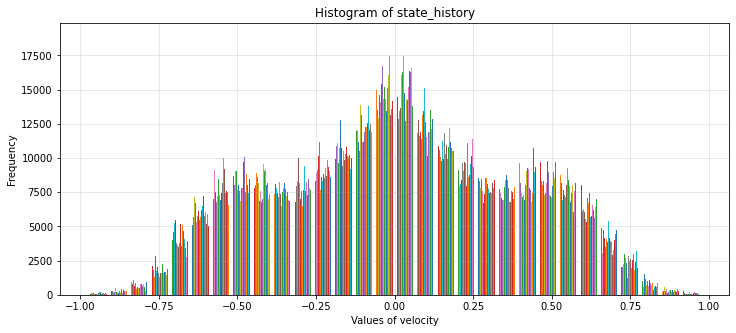

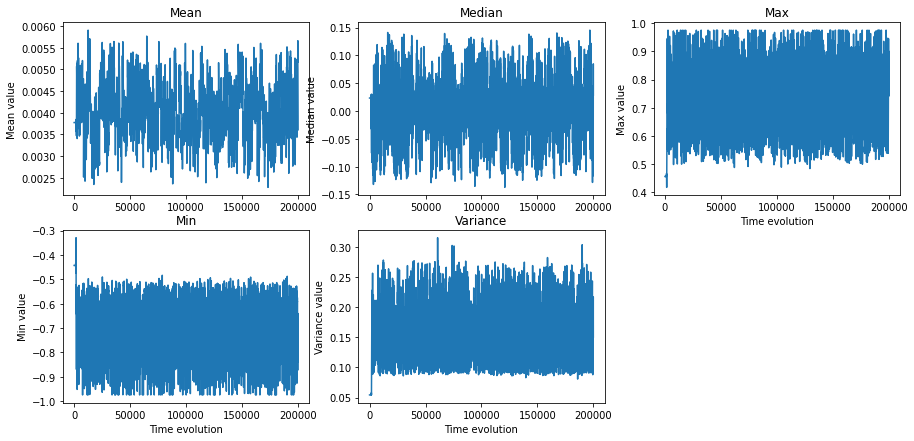

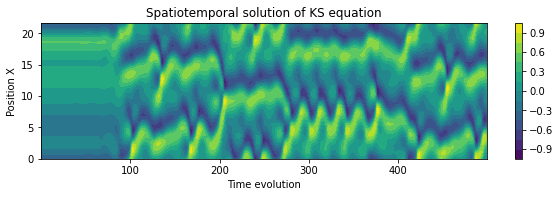

In [37]:
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-0.975,0.975))
state_history_norm = min_max_scaler.fit_transform(state_history)

#histogram
plothist(state_history_norm,bins=30)

#statistic values
statvalues(state_history_norm[0,:])

#evolution of statistic values
evolutionstat(state_history_norm)

#KSflow
drawKS(state_history_norm, position_x, time_counter ,startT=1,endT=int(time_counter[-1]), width = 10, divwidth = 4)

## Separating the data into training and test sets

In [10]:
state_history_norm=state_history_norm[:100000,:]
#até 100.000 vai, com 200.000 o colabs nao aguenta
state_history_norm.shape

(100000, 64)

In [0]:
size_conv_time=100
X = state_history_norm[:-size_conv_time,:] #our input: all the data excluding the last size_conv_time data
Y = state_history_norm[size_conv_time:,:] #our output: all the data minus the first size_conv_time one

NN = state_history_norm.shape[0]-2*size_conv_time
Nt = int(NN*0.9) # number of train
Nv = int(NN*0.1) # number of validation


np.random.seed(0)
indices=np.arange(NN)
np.random.shuffle(indices)
train_ind=indices[0:Nt]
valid_ind=indices[-Nv:]

X_train = np.zeros((Nt, sample_points, size_conv_time))
aux=0
for ind in train_ind:
    X_train[aux,:,:]=X[ind:ind+size_conv_time].T
    aux=aux+1

Y_train = Y[train_ind]

X_valid = np.zeros((Nv, sample_points, size_conv_time))
aux=0
for ind in valid_ind:
    X_valid[aux,:,:]=X[ind:ind+size_conv_time].T
    aux=aux+1

Y_valid = Y[valid_ind]


#converting to tensor
X_train_th = th.from_numpy(X_train).cuda()
Y_train_th = th.from_numpy(Y_train).cuda()
X_valid_th = th.from_numpy(X_valid).cuda()
Y_valid_th = th.from_numpy(Y_valid).cuda()

In [0]:
print(X_train_th.shape)
print(Y_train_th.shape)

torch.Size([89820, 64, 100])
torch.Size([89820, 64])


## Training

In [0]:
def train(model,X_train,X_valid,Y_train,Y_valid,epochs=1000,batch_size=64):
    Nt=len(X_train)
    Nv=len(X_valid)
    ### Mini-batching and shuffle
    idx = np.arange(Nt)
    nbatch = int(Nt/batch_size)
    train_losses,valid_losses=[],[]
    start_time=time.time()
    print("Epoch\tTrain Loss\tValid Loss")
    
    #Just to see the prediction of our random parameters
    model.eval()
    with th.no_grad():
        running_loss=0
        for bi in range(nbatch):
            ids = idx[bi*batch_size:(bi+1)*batch_size]
            x = X_train[ids]
            ttf_calc=model(x).squeeze()
            ttf = Y_train[ids]
            loss=loss_fn(ttf_calc,ttf)
            running_loss+=loss.item()
        train_losses.append(running_loss/nbatch)
        running_loss=0
        ttf_calc=model(X_valid).squeeze()
        ttf = Y_valid
        loss=loss_fn(ttf_calc,ttf)
        running_loss+=loss.item()
        valid_losses.append(running_loss)
        #it will print the result in epoch=0 during the training
    
    #starting the training here:
    for e in range(epochs):
        model.train()
        print("{}\t".format(e),"{:.5f}..\t".format(train_losses[-1]),"{:.5f}..".format(valid_losses[-1]))  
        np.random.shuffle(idx)
        running_loss=0
        for bi in range(nbatch):
            ids = idx[bi*batch_size:(bi+1)*batch_size]
            x = X_train[ids]
            optimizer.zero_grad()
            ttf_calc=model(x).squeeze()
            ttf = Y_train[ids]
            loss=loss_fn(ttf_calc,ttf)
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()
            
        # training is over for one epoch
        #now evaluate the model with the valid set:
        model.eval()
        accuracy=0
        train_losses.append(running_loss/nbatch)
        running_loss=0
        with th.no_grad():
            x = X_valid
            ttf_calc=model(x).squeeze()
            ttf = Y_valid
            loss=loss_fn(ttf_calc,ttf)
            running_loss+=loss.item()
            valid_losses.append(running_loss)
    print("{}\t".format(e+1),"{:.5f}..\t".format(train_losses[-1]),"{:.5f}..".format(valid_losses[-1]))     
    print("---------- Best : {:.3f}".format(min(valid_losses)), " at epoch " 
          , np.fromiter(valid_losses, dtype=np.float).argmin(), " / ",epochs )
    print('Execution time={:.2f}s'.format(time.time()-start_time))
    #plot some graphs
    plt.figure(figsize = (9, 1.5))
    ax= plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    ax.set_ylim(bottom=0)
    ax= plt.subplot(1, 2, 2)
    plt.plot(valid_losses)
    ax.set_ylim(bottom=0)
    return train_losses, valid_losses

## Model 1

In [3]:
Lin = 100
in_ch_conv_1 = 64
out_ch_conv_1 = 128
k_conv_1 = 10
st_conv_1 = 2
pad_conv_1 = 4
L_2 = (Lin+2*pad_conv_1-(k_conv_1-1)-1)/st_conv_1+1

k_pool_1= 2
st_pool_1= 2
L_3 = (L_2 - k_pool_1)/st_pool_1 + 1

in_ch_conv_2 = 128
out_ch_conv_2 = 64
k_conv_2 = 5
st_conv_2 = 2
pad_conv_2 = 1
L_4 = (L_3+2*pad_conv_2-(k_conv_2-1)-1)/st_conv_2+1

k_pool_2= 12
st_pool_2= 1
L_5 = (L_4 - k_pool_2)/st_pool_2 + 1

in_lin = sample_points
out_lin = sample_points


model = th.nn.Sequential(
    th.nn.Conv1d(in_ch_conv_1,out_ch_conv_1,k_conv_1,st_conv_1,pad_conv_1),
    th.nn.LeakyReLU(),
    th.nn.MaxPool1d(k_pool_1,st_pool_1),
    th.nn.Conv1d(in_ch_conv_2,out_ch_conv_2,k_conv_2,st_conv_2,pad_conv_2),
    th.nn.LeakyReLU(),
    th.nn.MaxPool1d(k_pool_2,st_pool_2),
    th.nn.Flatten(),
    th.nn.Linear(in_lin,out_lin),
    th.nn.Tanh(),
)
model.double()
model.cuda()
optimizer=th.optim.Adam(model.parameters(),lr=1e-5)
loss_fn=th.nn.MSELoss()

In [4]:
checkpoint = th.load("modelcv2_model1_u3")

# restore the model and optimizer states: 
#model = checkpoint['model']
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
batch_size = checkpoint['batch_size']
loss_fn=checkpoint['loss']
train_losses=checkpoint['training loss']
valid_losses=checkpoint['valid loss']

C:\Users\Callado\Anaconda3\lib\site-packages\torch\serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.loss.MSELoss' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Epoch	Train Loss	Valid Loss
0	 0.00004..	 0.00004..
1	 0.00004..	 0.00004..
2	 0.00004..	 0.00004..
3	 0.00004..	 0.00004..
4	 0.00004..	 0.00004..
5	 0.00004..	 0.00004..
6	 0.00004..	 0.00004..
7	 0.00004..	 0.00004..
8	 0.00004..	 0.00004..
9	 0.00004..	 0.00004..
10	 0.00004..	 0.00004..
11	 0.00004..	 0.00004..
12	 0.00004..	 0.00004..
13	 0.00004..	 0.00004..
14	 0.00004..	 0.00004..
15	 0.00004..	 0.00004..
16	 0.00004..	 0.00004..
17	 0.00004..	 0.00004..
18	 0.00004..	 0.00004..
19	 0.00004..	 0.00004..
20	 0.00004..	 0.00004..
21	 0.00004..	 0.00004..
22	 0.00004..	 0.00004..
23	 0.00004..	 0.00004..
24	 0.00004..	 0.00004..
25	 0.00004..	 0.00004..
26	 0.00004..	 0.00004..
27	 0.00004..	 0.00004..
28	 0.00004..	 0.00004..
29	 0.00004..	 0.00004..
30	 0.00004..	 0.00004..
31	 0.00004..	 0.00004..
32	 0.00004..	 0.00004..
33	 0.00004..	 0.00004..
34	 0.00004..	 0.00004..
35	 0.00004..	 0.00004..
36	 0.00004..	 0.00004..
37	 0.00004..	 0.00004..
38	 0.00004..	 0.00004..
39	 0.0

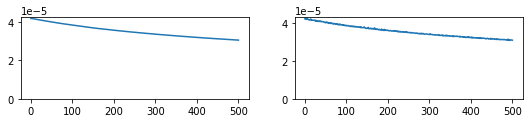

In [38]:
epochs_counter=500
batch_size=64
train_losses, valid_losses = train(model,X_train_th,X_valid_th,Y_train_th,Y_valid_th,epochs=epochs_counter,batch_size=batch_size)

In [29]:
model

Sequential(
  (0): Conv1d(64, 128, kernel_size=(10,), stride=(2,), padding=(4,))
  (1): LeakyReLU(negative_slope=0.01)
  (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv1d(128, 64, kernel_size=(5,), stride=(2,), padding=(1,))
  (4): LeakyReLU(negative_slope=0.01)
  (5): MaxPool1d(kernel_size=12, stride=1, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten()
  (7): Linear(in_features=64, out_features=64, bias=True)
  (8): Tanh()
)

In [0]:
#TO SAVE THE MODEL

# Here we create a dictionnary to store what we need: 
# 1/ the epoch number
# 2/ the batch size
# 2/ the paramters of the model
# 3/ the paramters of the optimizer
# 4/ the loss function we used
tosave_data = {'epoch': epochs_counter,
               'batch_size': batch_size,
               'model_state_dict': model.state_dict(),
               'optimizer_state_dict': optimizer.state_dict(),
               'loss': loss_fn,
               'training loss': train_losses,
               'valid loss': valid_losses,}
# Write a pickle file using pytorch 
th.save(tosave_data, "modelcv2_model1_u3")

Start_position= 200
The true solution:


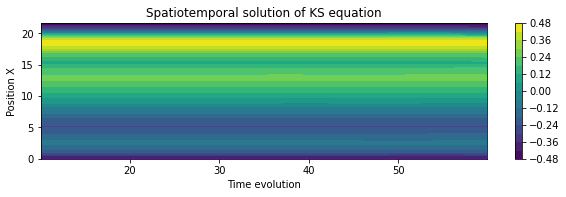

The model solution:


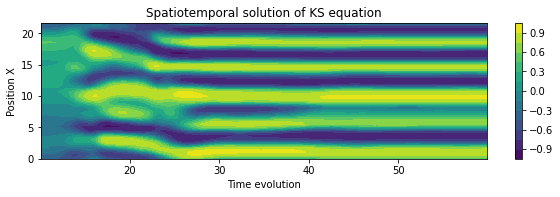

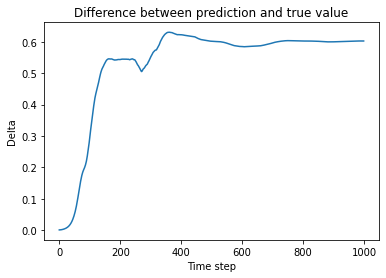

In [40]:
state_history_norm_th = th.from_numpy(state_history_norm).cuda()
#state_history_norm_th = state_history_norm_th.unsqueeze(0)
start_position=200
N_step_pred=1000
print('Start_position=', start_position)
prediction(model,start_position,N_step_pred,state_history_norm_th)


Start_position= 3000
The true solution:


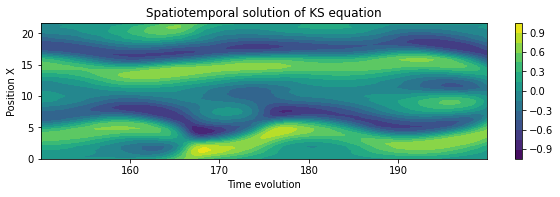

The model solution:


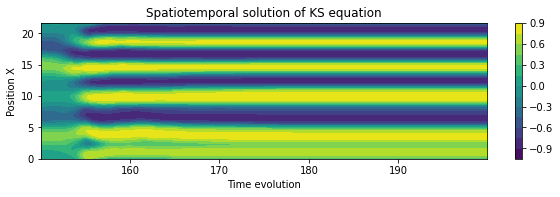

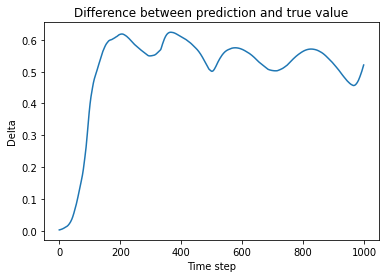

In [41]:
state_history_norm_th = th.from_numpy(state_history_norm).cuda()
#state_history_norm_th = state_history_norm_th.unsqueeze(0)
start_position=3000
N_step_pred=1000
print('Start_position=', start_position)
prediction(model,start_position,N_step_pred,state_history_norm_th)

## Model 2

In [0]:
Lin = size_conv_time
in_ch_conv_1 = sample_points
out_ch_conv_1 = 128
k_conv_1 = 10
st_conv_1 = 2
pad_conv_1 = 4
L_2 = (Lin+2*pad_conv_1-(k_conv_1-1)-1)/st_conv_1+1

k_pool_1= 2
st_pool_1= 2
L_3 = (L_2 - k_pool_1)/st_pool_1 + 1

in_ch_conv_2 = 128
out_ch_conv_2 = 64
k_conv_2 = 5
st_conv_2 = 2
pad_conv_2 = 1
L_4 = (L_3+2*pad_conv_2-(k_conv_2-1)-1)/st_conv_2+1

k_pool_2= 12
st_pool_2= 1
L_5 = (L_4 - k_pool_2)/st_pool_2 + 1

in_lin = sample_points
out_lin = sample_points
hidden_lin1 = sample_points*3
hidden_lin2 = sample_points*2


model = th.nn.Sequential(
    th.nn.Conv1d(in_ch_conv_1,out_ch_conv_1,k_conv_1,st_conv_1,pad_conv_1),
    th.nn.LeakyReLU(),
    th.nn.MaxPool1d(k_pool_1,st_pool_1),
    th.nn.Conv1d(in_ch_conv_2,out_ch_conv_2,k_conv_2,st_conv_2,pad_conv_2),
    th.nn.LeakyReLU(),
    th.nn.MaxPool1d(k_pool_2,st_pool_2),
    th.nn.Flatten(),
    th.nn.Linear(in_lin,hidden_lin1),
    th.nn.LeakyReLU(),
    th.nn.Linear(hidden_lin1,hidden_lin2),
    th.nn.Tanh(),
    th.nn.Linear(hidden_lin2,out_lin),
    th.nn.Tanh(),
)
model.double()
model.cuda()
optimizer=th.optim.Adam(model.parameters(),lr=1e-5)
loss_fn=th.nn.MSELoss()

Epoch	Train Loss	Valid Loss
0	 0.00002..	 0.00002..
1	 0.00002..	 0.00002..
2	 0.00002..	 0.00002..
3	 0.00002..	 0.00002..
4	 0.00002..	 0.00002..
5	 0.00002..	 0.00002..
6	 0.00002..	 0.00002..
7	 0.00002..	 0.00002..
8	 0.00002..	 0.00002..
9	 0.00002..	 0.00002..
10	 0.00002..	 0.00002..
11	 0.00002..	 0.00002..
12	 0.00002..	 0.00002..
13	 0.00002..	 0.00002..
14	 0.00002..	 0.00002..
15	 0.00002..	 0.00002..
16	 0.00002..	 0.00002..
17	 0.00002..	 0.00002..
18	 0.00002..	 0.00002..
19	 0.00002..	 0.00002..
20	 0.00002..	 0.00002..
21	 0.00002..	 0.00002..
22	 0.00002..	 0.00002..
23	 0.00002..	 0.00002..
24	 0.00002..	 0.00002..
25	 0.00002..	 0.00002..
26	 0.00002..	 0.00002..
27	 0.00002..	 0.00002..
28	 0.00002..	 0.00002..
29	 0.00002..	 0.00002..
30	 0.00002..	 0.00002..
31	 0.00002..	 0.00002..
32	 0.00002..	 0.00002..
33	 0.00002..	 0.00002..
34	 0.00002..	 0.00002..
35	 0.00002..	 0.00002..
36	 0.00002..	 0.00002..
37	 0.00002..	 0.00002..
38	 0.00002..	 0.00002..
39	 0.0

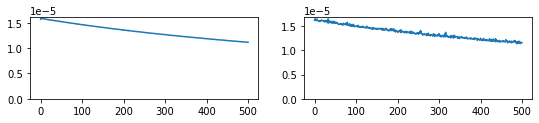

In [54]:
epochs_counter=500
batch_size=64
train_losses, valid_losses = train(model,X_train_th,X_valid_th,Y_train_th,Y_valid_th,epochs=epochs_counter,batch_size=batch_size)

In [49]:
model

Sequential(
  (0): Conv1d(64, 128, kernel_size=(10,), stride=(2,), padding=(4,))
  (1): LeakyReLU(negative_slope=0.01)
  (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv1d(128, 64, kernel_size=(5,), stride=(2,), padding=(1,))
  (4): LeakyReLU(negative_slope=0.01)
  (5): MaxPool1d(kernel_size=12, stride=1, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten()
  (7): Linear(in_features=64, out_features=192, bias=True)
  (8): LeakyReLU(negative_slope=0.01)
  (9): Linear(in_features=192, out_features=128, bias=True)
  (10): Tanh()
  (11): Linear(in_features=128, out_features=64, bias=True)
  (12): Tanh()
)

In [0]:
#TO SAVE THE MODEL

# Here we create a dictionnary to store what we need: 
# 1/ the epoch number
# 2/ the batch size
# 2/ the paramters of the model
# 3/ the paramters of the optimizer
# 4/ the loss function we used
tosave_data = {'epoch': epochs_counter,
               'batch_size': batch_size,
               'model_state_dict': model.state_dict(),
               'optimizer_state_dict': optimizer.state_dict(),
               'loss': loss_fn,
               'training loss': train_losses,
               'valid loss': valid_losses,}
# Write a pickle file using pytorch 
th.save(tosave_data, "modelcv2_model2_u3")

Start_position= 200
The true solution:


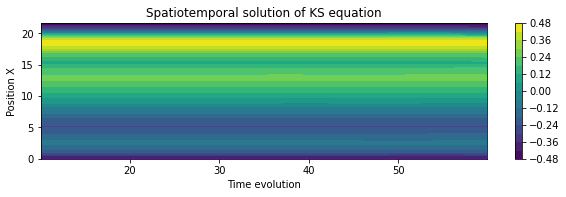

The model solution:


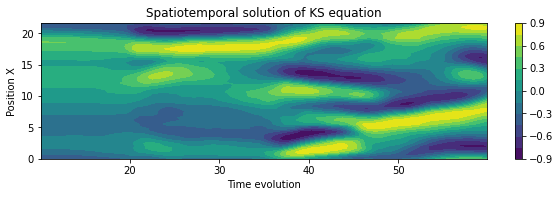

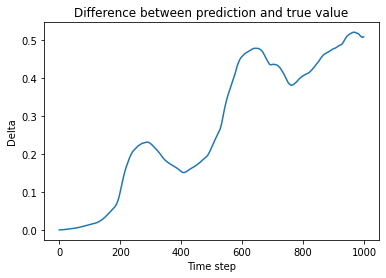

In [60]:
state_history_norm_th = th.from_numpy(state_history_norm).cuda()
#state_history_norm_th = state_history_norm_th.unsqueeze(0)
start_position=200
N_step_pred=1000
print('Start_position=', start_position)
prediction(model,start_position,N_step_pred,state_history_norm_th)

Start_position= 3000
The true solution:


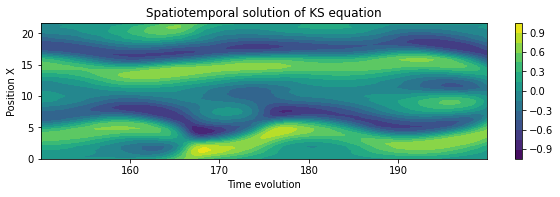

The model solution:


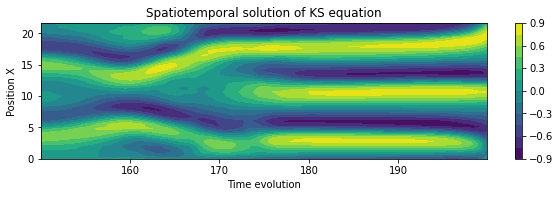

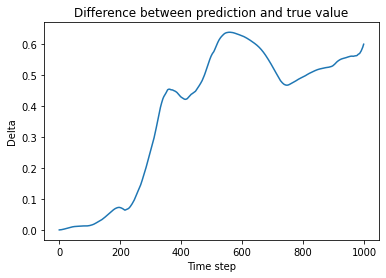

In [57]:
state_history_norm_th = th.from_numpy(state_history_norm).cuda()
#state_history_norm_th = state_history_norm_th.unsqueeze(0)
start_position=3000
N_step_pred=1000
print('Start_position=', start_position)
prediction(model,start_position,N_step_pred,state_history_norm_th)

Sequential(
  (0): Conv1d(64, 128, kernel_size=(10,), stride=(2,), padding=(4,))
  (1): LeakyReLU(negative_slope=0.01)
  (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv1d(128, 64, kernel_size=(5,), stride=(2,), padding=(1,))
  (4): LeakyReLU(negative_slope=0.01)
  (5): MaxPool1d(kernel_size=12, stride=1, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten()
  (7): Linear(in_features=64, out_features=192, bias=True)
  (8): LeakyReLU(negative_slope=0.01)
  (9): Linear(in_features=192, out_features=128, bias=True)
  (10): Tanh()
  (11): Linear(in_features=128, out_features=64, bias=True)
  (12): Tanh()
)
Model's state_dict:
0.weight 	 torch.Size([128, 64, 10])
0.bias 	 torch.Size([128])
3.weight 	 torch.Size([64, 128, 5])
3.bias 	 torch.Size([64])
7.weight 	 torch.Size([192, 64])
7.bias 	 torch.Size([192])
9.weight 	 torch.Size([128, 192])
9.bias 	 torch.Size([128])
11.weight 	 torch.Size([64, 128])
11.bias 	 torch.Size([64])
epoch: 500
batch

(0, 0.002559431239274406)

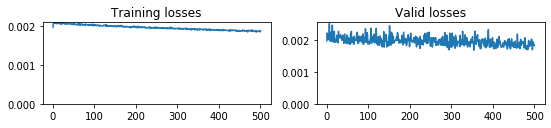

In [0]:
#TO LOAD THE MODEL

# First create objects of the good types 
Lin = size_conv_time
in_ch_conv_1 = sample_points
out_ch_conv_1 = 128
k_conv_1 = 10
st_conv_1 = 2
pad_conv_1 = 4
L_2 = (Lin+2*pad_conv_1-(k_conv_1-1)-1)/st_conv_1+1

k_pool_1= 2
st_pool_1= 2
L_3 = (L_2 - k_pool_1)/st_pool_1 + 1

in_ch_conv_2 = 128
out_ch_conv_2 = 64
k_conv_2 = 5
st_conv_2 = 2
pad_conv_2 = 1
L_4 = (L_3+2*pad_conv_2-(k_conv_2-1)-1)/st_conv_2+1

k_pool_2= 12
st_pool_2= 1
L_5 = (L_4 - k_pool_2)/st_pool_2 + 1

in_lin = sample_points
out_lin = sample_points
hidden_lin1 = sample_points*3
hidden_lin2 = sample_points*2


model = th.nn.Sequential(
    th.nn.Conv1d(in_ch_conv_1,out_ch_conv_1,k_conv_1,st_conv_1,pad_conv_1),
    th.nn.LeakyReLU(),
    th.nn.MaxPool1d(k_pool_1,st_pool_1),
    th.nn.Conv1d(in_ch_conv_2,out_ch_conv_2,k_conv_2,st_conv_2,pad_conv_2),
    th.nn.LeakyReLU(),
    th.nn.MaxPool1d(k_pool_2,st_pool_2),
    th.nn.Flatten(),
    th.nn.Linear(in_lin,hidden_lin1),
    th.nn.LeakyReLU(),
    th.nn.Linear(hidden_lin1,hidden_lin2),
    th.nn.Tanh(),
    th.nn.Linear(hidden_lin2,out_lin),
    th.nn.Tanh(),
)
model.double()
model.cuda()
optimizer=th.optim.Adam(model.parameters(),lr=1e-4)
loss_fn=th.nn.L1Loss()

# Load the pickle file to read the dictionnary from the file
checkpoint = th.load("modelcv2_model2_u3")

# restore the model and optimizer states: 
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
batch_size = checkpoint['batch_size']
loss_fn=checkpoint['loss']
train_losses=checkpoint['training loss']
valid_losses=checkpoint['valid loss']


# Print model's state_dict
print(model)
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
print("epoch:", epoch)
print("batch_size:", batch_size)
print("loss:", loss_fn)
    
# Print optimizer's state_dict
#print("Optimizer's state_dict:")
#for var_name in optimizer.state_dict():
#    print(var_name, "\t", optimizer.state_dict()[var_name])

#plot some graphs
plt.figure(figsize = (9, 1.5))
ax= plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training losses')
ax.set_ylim(bottom=0)
ax= plt.subplot(1, 2, 2)
plt.plot(valid_losses)
plt.title('Valid losses')
ax.set_ylim(bottom=0)

In [0]:
state_history_norm_th = th.from_numpy(state_history_norm).cuda()
#state_history_norm_th = state_history_norm_th.unsqueeze(0)
start_position=8000
N_step_pred=500
prediction(model,start_position,N_step_pred,state_history_norm_th)

RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 2.00 GiB total capacity; 215.66 MiB already allocated; 447.20 KiB free; 218.00 MiB reserved in total by PyTorch)